# Imaging and structure analysis of ferroelectric domains, domain walls, and vortices by scanning electron diffraction

Ursula Ludacka<sup>1</sup>, Jiali He<sup>1</sup>, Shuyu Qin<sup>3,4</sup>, Manuel Zahn<sup>1,5</sup>, Emil Frang Christiansen<sup>2</sup>, Kasper A. Hunnestad<sup>1</sup>, Zewu Yan<sup>6,7</sup>, Edith Bourret<sup>7</sup>, István Kézsmárki<sup>5</sup>, Antonius T. J. van Helvoort<sup>2</sup>, Joshua Agar<sup>3,4</sup>, Dennis Meier<sup>1</sup>

Email: dennis.meier@ntnu.no, jca92@drexel.edu

<sup>1</sup> Department of Materials Science and Engineering, NTNU Norwegian University of Science and Technology, Trondheim, Norway \
<sup>2</sup> Department of Physics, NTNU Norwegian University of Science and Technology, Trondheim, Norway\
<sup>3</sup> Department of Materials Science and Engineering, Lehigh University, Bethlehem, USA\
<sup>4</sup> Department of Mechanical Engineering and Mechanics, Drexel University, Philadelphia, USA\
<sup>5</sup> Experimental Physics V, University of Augsburg, Augsburg, Germany\
<sup>6</sup> Department of Physics, ETH Zurich, Zürich, Switzerland.\
<sup>7</sup> Materials Sciences Division, Lawrence Berkeley National Laboratory, Berkeley, USA.


## Abstract

Direct electron detectors in scanning transmission electron microscopy give unprecedented possibilities for structure analysis at the nanoscale. In electronic and quantum materials, this new capability gives access to, for example, emergent chiral structures and symmetry-breaking distortions that underpin functional properties. Quantifying nanoscale structural features with statistical significance, however, is complicated by the subtleties of dynamic diffraction and coexisting contrast mechanisms, which often results in low signal-to-noise and the superposition of multiple signals that are challenging to deconvolute. Here we apply scanning electron diffraction to explore local polar distortions in the uniaxial ferroelectric Er(Mn,Ti)O3. Using a custom-designed convolutional autoencoder with bespoke regularization, we demonstrate that subtle variations in the scattering signatures of ferroelectric domains, domain walls, and vortex textures can readily be disentangled with statistical significance and separated from extrinsic contributions due to, e.g., variations in specimen thickness or bending. The work demonstrates a pathway to quantitatively measure symmetry-breaking distortions across large areas, mapping structural changes at interfaces and topological structures with nanoscale spatial resolution.


## Imports and settings


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install -r dev_requirements/nb_requirements.txt
# !pip freeze
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
# !python -m pip uninstall torch torchvision torchaudio -y
# !pip uninstall m3_learning
# !pip install -r dev_requirements/nb_requirements.txt
# !pip install -r dev_requirements/dev-requirements.txt
# !pip install "m3_learning @ file:///C:/Users/ljg23/PycharmProjects/ConvAutoenc_MScProj/m3_learning"
import importlib
importlib.reload

<function importlib.reload(module)>

In [2]:
import torch, os, sys
print("torch version  :", torch.__version__)
print("compiled for   :", torch.version.cuda)
print("CUDA available :", torch.cuda.is_available())

torch version  : 2.7.1+cu126
compiled for   : 12.6
CUDA available : True


In [3]:
import hyperspy
print("hyperspy version :", hyperspy.__version__)

hyperspy version : 2.3.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import hyperspy.api as hs
import torch
from m3_learning.nn.random import random_seed
from m3_learning.nn.STEM_AE.Viz import Viz
from m3_learning.nn.STEM_AE.STEM_AE import ConvAutoencoder
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.Movies import make_movie
from m3_learning.nn.STEM_AE.Dataset import STEM_Dataset
from m3_learning.util.file_IO import download_and_unzip
import py4DSTEM as p4
from pathlib import Path
import os

# Specify the filename and the path to save the file
save_path = "DUMMY_SAVEDATA"

# builds the printer object
printing = printer(basepath=save_path)

# Set the style of the plots
set_style("printing")

# Set the random seed for reproducibility
random_seed(seed=42)


printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Domains

### Loads the Dataset


In [3]:
path = Path("E:\Lu Joseph\Diffraction_SI\Diffraction_SI.dm4")

dc = p4.io.import_file(path,                 # auto-detects “dm” type
                       mem='MEMMAP')         # or 'RAM' for small cubes
print(dc)       # -> (Ny, Nx, Nq_y, Nq_x) plus rich metadata
print(dc.shape)
Ny = dc.shape[0]
Nx = dc.shape[1]

# s = hs.signals.Signal2D(dc.data)
# s.save(f"{save_path}/Diffraction_SI.hspy")

# loads the dataset
domain = STEM_Dataset(
    data_path=f"{save_path}/Diffraction_SI.hspy"
)

DataCube( A 4-dimensional array of shape (42, 114, 512, 512) called 'dm_dataset',
          with dimensions:

              Rx = [0.0,0.49195072054862976,0.9839014410972595,...] nm
              Ry = [0.0,0.49195072054862976,0.9839014410972595,...] nm
              Qx = [0.0,0.016712141036987305,0.03342428207397461,...] A^-1
              Qy = [0.0,0.016712141036987305,0.03342428207397461,...] A^-1
)
(42, 114, 512, 512)


In [15]:
# Sanity: the two scan axes (Rx, Ry) should multiply to 42×114 = 4788 patterns
Ny, Nx, Hdet, Wdet = dc.shape
assert Ny * Nx == 4788, "Unexpected navigation shape"
assert Hdet == Wdet == 512, "Detector pixels are not 512×512!"

print("len(domain)             :", len(domain.data))
print("domain[0].shape         :", domain.data[0].shape)
print(dir(domain))

len(domain)             : 42
domain[0].shape         : (114, 512, 512)
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_log_data', 'data', 'log_data']


In [6]:
print(len(dc[0]))
print(domain.data[0].shape)

114
(114, 512, 512)


### Instantiates the Visualizer


In [9]:
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 250, "scale length": 100, "units": "nm", "channel": -1}

### Visualizes the Raw Data


DUMMY_SAVEDATA/STEM_raw_and_virtual_domain.png
DUMMY_SAVEDATA/STEM_raw_and_virtual_domain.svg


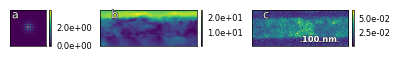

In [ ]:
bright_field_ = (246, 266, 246, 266)
dark_field_ = (300, 330, 100, 130)
filename = "/STEM_raw_and_virtual_domain"
viz.STEM_raw_and_virtual(
    domain,
    bright_field_=bright_field_,
    dark_field_=dark_field_,
    scalebar_=True,
    filename=filename,
    shape_=domain.data.shape,
)

### Builds the Neural Network Model


In [4]:
encoder_step_size = [512, 512]
pooling_list = [4, 4, 2]
decoder_step_size = [16, 16]
upsampling_list = [2, 4, 4]
embedding_size = 32
conv_size = 128

# set device to load model
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

model = ConvAutoencoder(
    encoder_step_size=encoder_step_size,
    pooling_list=pooling_list,
    decoder_step_size=decoder_step_size,
    upsampling_list=upsampling_list,
    embedding_size=embedding_size,
    conv_size=conv_size,
    device=device,
    learning_rate=3e-5,
)


### Trains or Loads Pretrained Weights


In [5]:
# set retrain parameter
train = True

if train:
    model.Train(
        domain.log_data,
        coef_1=1e-5,
        epochs=1,
        with_scheduler=False,
        folder_path=f"{save_path}/domain_weights",
        batch_size=8,
    )
else:
    model.load_weights(
        f"{save_path}/domain_weights/Weight_epoch_0000_l1coef_0.0000_lr_0.00003_trainloss_0.0322.pkl"
    )

100%|██████████| 599/599 [07:21<00:00,  1.36it/s]


Epoch: 000/001 | Train Loss: 0.0309
.............................


### Computes the Embeddings


In [6]:
# ---------------------------------------------------------------------
# 1.  Helper that prints tensor shapes layer-by-layer
# ---------------------------------------------------------------------
def spy_encoder_shapes(model: torch.nn.Module, x: torch.Tensor) -> None:
    """
    Print the output shape after every Conv2d and MaxPool2d layer
    while running a single forward pass.

    Parameters
    ----------
    model : nn.Module
        The encoder (or any nn.Module) you want to inspect.
    x : torch.Tensor
        A mini-batch ready for input, e.g. shape (B, 1, H, W).
    """
    hooks = []

    # register a forward hook on each layer we care about -------------
    def _make_hook(name):
        def hook(_module, _in, out):
            if isinstance(out, torch.Tensor):
                print(f"{name:25s} ⟶ {tuple(out.shape)}")
        return hook

    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.MaxPool2d)):
            hooks.append(module.register_forward_hook(_make_hook(name)))

    # run a single inference pass -------------------------------------
    model.eval()
    with torch.no_grad():
        _ = model(x.to(next(model.parameters()).device))

    # tidy up ----------------------------------------------------------
    for h in hooks:
        h.remove()


In [7]:
loader  = torch.utils.data.DataLoader(domain, batch_size=2, shuffle=False)
batch   = next(iter(loader))                # (2, 512, 512)
print("Batch shape:", batch.shape)
pattern = batch.unsqueeze(1).float()        # (2, 1, 512, 512)
print("Pattern shape:", pattern.shape)
spy_encoder_shapes(model.encoder, pattern)

Batch shape: torch.Size([2, 512, 512])
Pattern shape: torch.Size([2, 1, 512, 512])
cov2d                     ⟶ (2, 128, 512, 512)
block_layer.0.cov1d_1     ⟶ (2, 128, 512, 512)
block_layer.0.cov1d_2     ⟶ (2, 128, 512, 512)
block_layer.0.cov1d_3     ⟶ (2, 128, 512, 512)
block_layer.1.cov1d_1     ⟶ (2, 128, 512, 512)
block_layer.2             ⟶ (2, 128, 128, 128)
block_layer.3.cov1d_1     ⟶ (2, 128, 128, 128)
block_layer.3.cov1d_2     ⟶ (2, 128, 128, 128)
block_layer.3.cov1d_3     ⟶ (2, 128, 128, 128)
block_layer.4.cov1d_1     ⟶ (2, 128, 128, 128)
block_layer.5             ⟶ (2, 128, 32, 32)
block_layer.6.cov1d_1     ⟶ (2, 128, 32, 32)
block_layer.6.cov1d_2     ⟶ (2, 128, 32, 32)
block_layer.6.cov1d_3     ⟶ (2, 128, 32, 32)
block_layer.7.cov1d_1     ⟶ (2, 128, 32, 32)
block_layer.8             ⟶ (2, 128, 16, 16)
cov2d_1                   ⟶ (2, 128, 16, 16)


In [6]:
embedding = model.get_embedding(domain.log_data, batch_size=512)


Yeah baby, yeah!


100%|██████████| 10/10 [27:29<00:00, 164.97s/it]


In [7]:
np.save("embedding_SI_dummy_11_07_model_512.npy", embedding)

In [12]:

embedding = np.load("DUMMY_SAVEDATA\embeddings\embedding_SI_dummy_11_07_model_512.npy")
print(embedding.shape)
print(embedding)

Ny = dc.shape[0]
Nx = dc.shape[1]
print("Nx, Ny: ", Nx, Ny)
n_emb, d_latent = embedding.shape
print("n_emb: ", n_emb)

total_scan_positions = Nx * Ny               # 4788
rep_factor = n_emb // total_scan_positions   # 19152 // 4788  ➜  4
assert n_emb % total_scan_positions == 0

latent_cube = embedding.reshape(Ny, Nx, d_latent)
# latent_cube.shape ➜ (4, 114, 42, 32)
print("latent cube shape: ", latent_cube.shape)



(4788, 32)
[[0.         0.         0.01073889 ... 0.23169085 0.         0.        ]
 [0.         0.         0.00790486 ... 0.23843274 0.00610274 0.        ]
 [0.         0.         0.00715085 ... 0.2329944  0.00533139 0.        ]
 ...
 [0.07412172 0.         0.         ... 0.47072247 0.04514575 0.        ]
 [0.07570212 0.         0.         ... 0.47013235 0.04934233 0.        ]
 [0.08175099 0.         0.         ... 0.47311464 0.03985807 0.        ]]
Nx, Ny:  114 42
n_emb:  4788
latent cube shape:  (42, 114, 32)


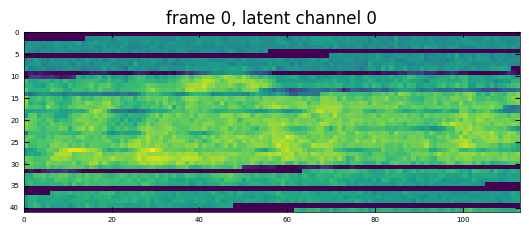

In [14]:
frame   = 0        # 0‒3
channel = 0        # 0‒31

img = latent_cube[:, :, channel]

plt.imshow(img, cmap="viridis",
           extent=[0, Nx-1, Ny-1, 0])   # or use physical Rx/Ry vectors
plt.title(f"frame {frame}, latent channel {channel}")
plt.show()

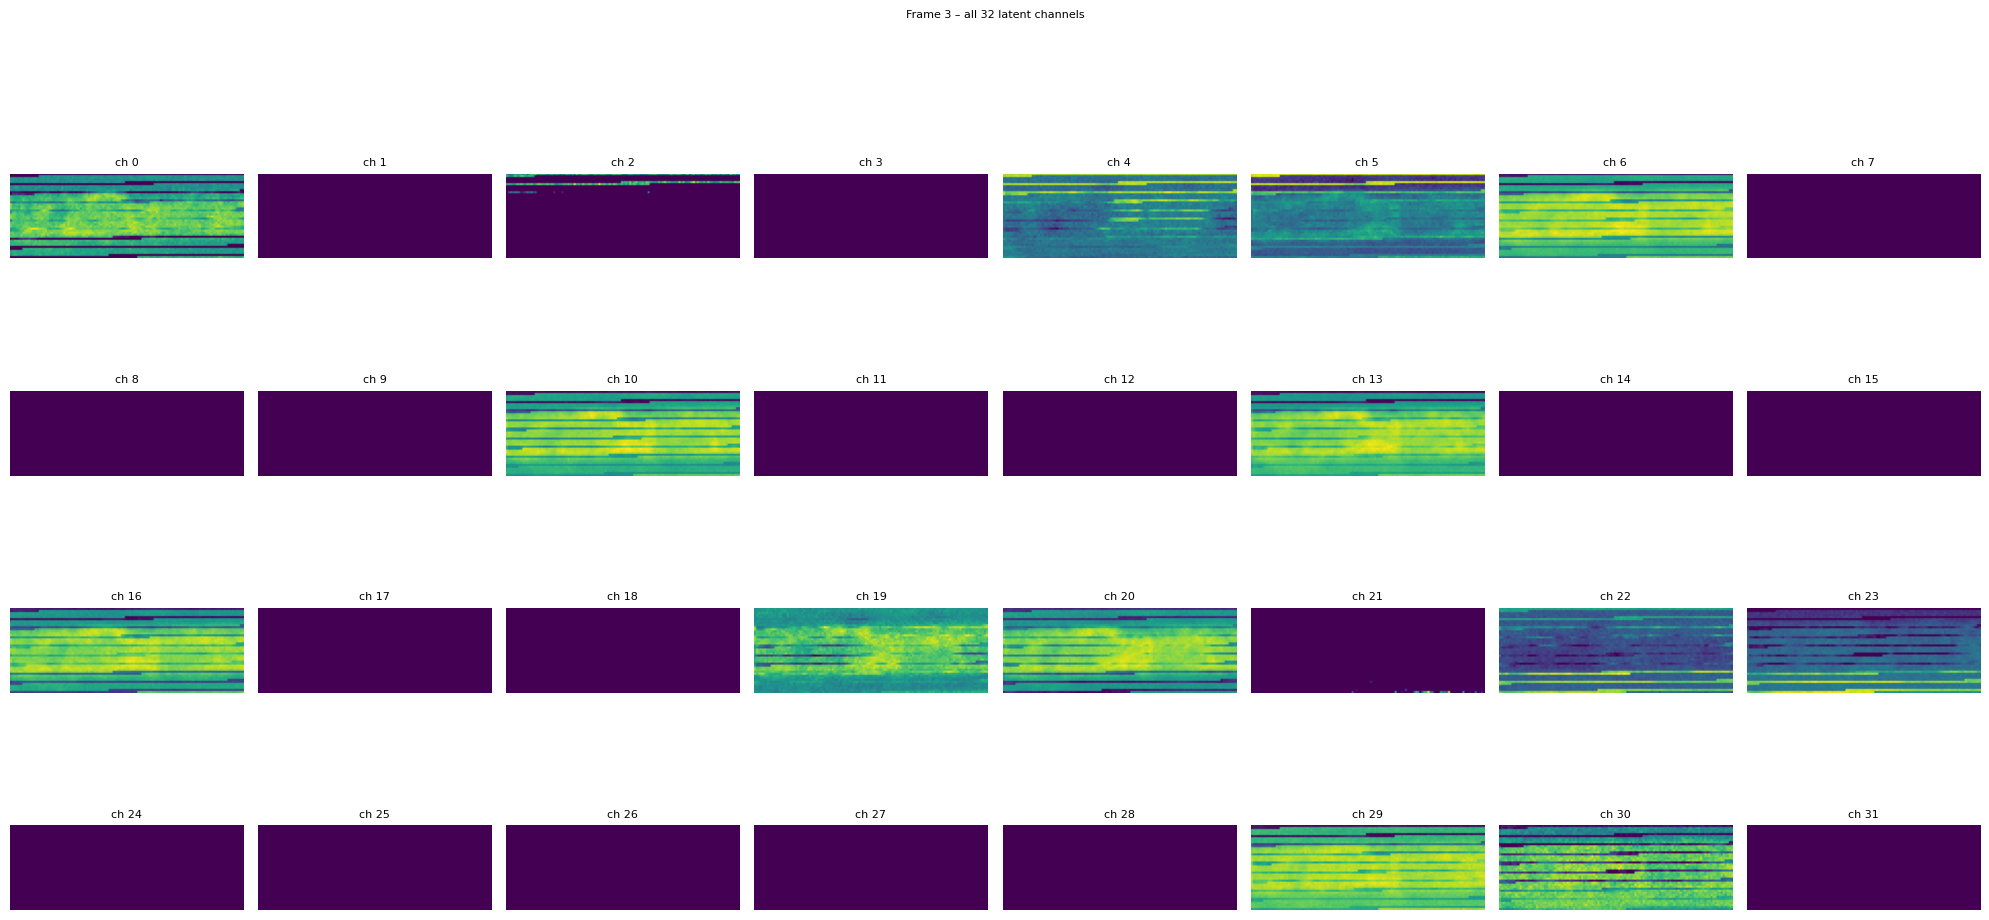

In [15]:
frame   = 3        # which frame to visualise
n_ch    = 32       # number of latent channels
ncols   = 8        # columns in the grid
nrows   = n_ch // ncols

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(2.5 * ncols, 2.5 * nrows),
                         squeeze=False)

for ch in range(n_ch):
    r, c = divmod(ch, ncols)          # row & column index
    ax   = axes[r, c]

    img = latent_cube[:, :, ch]
    ax.imshow(img,
              cmap="viridis",
              extent=[0, Nx - 1, Ny - 1, 0])   # or use Rx/Ry for physical coords
    ax.set_title(f"ch {ch}", fontsize=8)
    ax.axis("off")

plt.suptitle(f"Frame {frame} – all {n_ch} latent channels", y=1.02)
plt.tight_layout()
plt.savefig(f"{save_path}/latent_vis_test_frame{frame}.png")
plt.show()

### Visualizes the Embeddings


DUMMY_SAVEDATA/domain wall_embedding_maps.png
DUMMY_SAVEDATA/domain wall_embedding_maps.svg


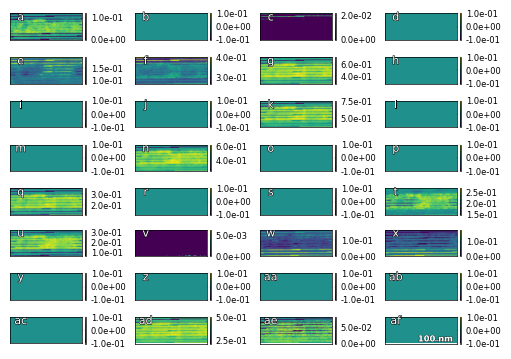

In [10]:
viz.channels = None
viz.scalebar_ = {"width": 250, "scale length": 100, "units": "nm"}
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    name="/domain wall",
    shape_=domain.log_data.shape,
    figsize=(5, 8),
)

### Generates Data from the Latent Space


In [ ]:
model.embedding = embedding
viz.model = model
viz.channels = [20, 29]
ranges = [[0, 0.018], [0, 0.022]]
folder_name = "Generator_of_Figure_4_a_d"

viz.generator_images(
    ranges=ranges,
    folder_name=folder_name,
    figsize=(5, 1.25),
    cbar_number_format="%d",
    shape_=domain.data.shape,
    divider_=False,
)

  0%|          | 0/200 [00:00<?, ?it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0000_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0000_maps.svg


  0%|          | 1/200 [00:01<03:34,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0001_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0001_maps.svg


  1%|          | 2/200 [00:02<03:32,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0002_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0002_maps.svg


  2%|▏         | 3/200 [00:03<03:50,  1.17s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0003_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0003_maps.svg


  2%|▏         | 4/200 [00:04<03:41,  1.13s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0004_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0004_maps.svg


  2%|▎         | 5/200 [00:05<03:36,  1.11s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0005_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0005_maps.svg


  3%|▎         | 6/200 [00:06<03:33,  1.10s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0006_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0006_maps.svg


  4%|▎         | 7/200 [00:07<03:30,  1.09s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0007_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0007_maps.svg


  4%|▍         | 8/200 [00:08<03:28,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0008_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0008_maps.svg


  4%|▍         | 9/200 [00:09<03:26,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0009_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0009_maps.svg


  5%|▌         | 10/200 [00:10<03:24,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0010_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0010_maps.svg


  6%|▌         | 11/200 [00:12<03:23,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0011_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0011_maps.svg


  6%|▌         | 12/200 [00:13<03:32,  1.13s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0012_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0012_maps.svg


  6%|▋         | 13/200 [00:14<03:28,  1.11s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0013_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0013_maps.svg


  7%|▋         | 14/200 [00:15<03:24,  1.10s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0014_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0014_maps.svg


  8%|▊         | 15/200 [00:16<03:21,  1.09s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0015_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0015_maps.svg


  8%|▊         | 16/200 [00:17<03:19,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0016_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0016_maps.svg


  8%|▊         | 17/200 [00:18<03:17,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0017_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0017_maps.svg


  9%|▉         | 18/200 [00:19<03:16,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0018_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0018_maps.svg


 10%|▉         | 19/200 [00:20<03:14,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0019_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0019_maps.svg


 10%|█         | 20/200 [00:21<03:13,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0020_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0020_maps.svg


 10%|█         | 21/200 [00:22<03:12,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0021_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0021_maps.svg


 11%|█         | 22/200 [00:23<03:10,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0022_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0022_maps.svg


 12%|█▏        | 23/200 [00:25<03:21,  1.14s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0023_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0023_maps.svg


 12%|█▏        | 24/200 [00:26<03:16,  1.12s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0024_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0024_maps.svg


 12%|█▎        | 25/200 [00:27<03:13,  1.10s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0025_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0025_maps.svg


 13%|█▎        | 26/200 [00:28<03:10,  1.09s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0026_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0026_maps.svg


 14%|█▎        | 27/200 [00:29<03:08,  1.09s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0027_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0027_maps.svg


 14%|█▍        | 28/200 [00:30<03:06,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0028_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0028_maps.svg


 14%|█▍        | 29/200 [00:31<03:04,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0029_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0029_maps.svg


 15%|█▌        | 30/200 [00:32<03:03,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0030_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0030_maps.svg


 16%|█▌        | 31/200 [00:33<03:01,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0031_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0031_maps.svg


 16%|█▌        | 32/200 [00:34<03:00,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0032_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0032_maps.svg


 16%|█▋        | 33/200 [00:35<02:59,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0033_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0033_maps.svg


 17%|█▋        | 34/200 [00:37<02:57,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0034_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0034_maps.svg


 18%|█▊        | 35/200 [00:38<02:56,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0035_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0035_maps.svg


 18%|█▊        | 36/200 [00:39<02:55,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0036_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0036_maps.svg


 18%|█▊        | 37/200 [00:40<03:07,  1.15s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0037_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0037_maps.svg


 19%|█▉        | 38/200 [00:41<03:02,  1.13s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0038_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0038_maps.svg


 20%|█▉        | 39/200 [00:42<02:58,  1.11s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0039_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0039_maps.svg


 20%|██        | 40/200 [00:43<02:55,  1.10s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0040_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0040_maps.svg


 20%|██        | 41/200 [00:44<02:53,  1.09s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0041_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0041_maps.svg


 21%|██        | 42/200 [00:45<02:51,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0042_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0042_maps.svg


 22%|██▏       | 43/200 [00:46<02:49,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0043_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0043_maps.svg


 22%|██▏       | 44/200 [00:48<02:47,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0044_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0044_maps.svg


 22%|██▎       | 45/200 [00:49<02:46,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0045_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0045_maps.svg


 23%|██▎       | 46/200 [00:50<02:45,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0046_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0046_maps.svg


 24%|██▎       | 47/200 [00:51<02:43,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0047_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0047_maps.svg


 24%|██▍       | 48/200 [00:52<02:42,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0048_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0048_maps.svg


 24%|██▍       | 49/200 [00:53<02:41,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0049_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0049_maps.svg


 25%|██▌       | 50/200 [00:54<02:40,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0050_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0050_maps.svg


 26%|██▌       | 51/200 [00:55<02:39,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0051_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0051_maps.svg


 26%|██▌       | 52/200 [00:56<02:38,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0052_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0052_maps.svg


 26%|██▋       | 53/200 [00:57<02:37,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0053_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0053_maps.svg


 27%|██▋       | 54/200 [00:58<02:36,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0054_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0054_maps.svg


 28%|██▊       | 55/200 [01:00<02:49,  1.17s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0055_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0055_maps.svg


 28%|██▊       | 56/200 [01:01<02:43,  1.14s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0056_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0056_maps.svg


 28%|██▊       | 57/200 [01:02<02:39,  1.12s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0057_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0057_maps.svg


 29%|██▉       | 58/200 [01:03<02:36,  1.10s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0058_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0058_maps.svg


 30%|██▉       | 59/200 [01:04<02:33,  1.09s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0059_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0059_maps.svg


 30%|███       | 60/200 [01:05<02:31,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0060_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0060_maps.svg


 30%|███       | 61/200 [01:06<02:30,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0061_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0061_maps.svg


 31%|███       | 62/200 [01:07<02:28,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0062_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0062_maps.svg


 32%|███▏      | 63/200 [01:08<02:27,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0063_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0063_maps.svg


 32%|███▏      | 64/200 [01:09<02:25,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0064_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0064_maps.svg


 32%|███▎      | 65/200 [01:10<02:24,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0065_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0065_maps.svg


 33%|███▎      | 66/200 [01:11<02:23,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0066_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0066_maps.svg


 34%|███▎      | 67/200 [01:12<02:22,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0067_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0067_maps.svg


 34%|███▍      | 68/200 [01:13<02:20,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0068_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0068_maps.svg


 34%|███▍      | 69/200 [01:15<02:19,  1.06s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0069_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0069_maps.svg


 35%|███▌      | 70/200 [01:16<02:18,  1.06s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0070_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0070_maps.svg


 36%|███▌      | 71/200 [01:17<02:17,  1.06s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0071_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0071_maps.svg


 36%|███▌      | 72/200 [01:18<02:16,  1.06s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0072_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0072_maps.svg


 36%|███▋      | 73/200 [01:19<02:14,  1.06s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0073_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0073_maps.svg


 37%|███▋      | 74/200 [01:20<02:13,  1.06s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0074_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0074_maps.svg


 38%|███▊      | 75/200 [01:21<02:12,  1.06s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0075_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0075_maps.svg


 38%|███▊      | 76/200 [01:22<02:26,  1.18s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0076_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0076_maps.svg


 38%|███▊      | 77/200 [01:23<02:20,  1.15s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0077_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0077_maps.svg


 39%|███▉      | 78/200 [01:24<02:16,  1.12s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0078_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0078_maps.svg


 40%|███▉      | 79/200 [01:26<02:13,  1.11s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0079_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0079_maps.svg


 40%|████      | 80/200 [01:27<02:11,  1.09s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0080_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0080_maps.svg


 40%|████      | 81/200 [01:28<02:09,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0081_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0081_maps.svg


 41%|████      | 82/200 [01:29<02:07,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0082_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0082_maps.svg


 42%|████▏     | 83/200 [01:30<02:05,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0083_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0083_maps.svg


 42%|████▏     | 84/200 [01:31<02:04,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0084_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0084_maps.svg


 42%|████▎     | 85/200 [01:32<02:03,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0085_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0085_maps.svg


 43%|████▎     | 86/200 [01:33<02:01,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0086_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0086_maps.svg


 44%|████▎     | 87/200 [01:34<02:00,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0087_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0087_maps.svg


 44%|████▍     | 88/200 [01:35<01:59,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0088_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0088_maps.svg


 44%|████▍     | 89/200 [01:36<01:58,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0089_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0089_maps.svg


 45%|████▌     | 90/200 [01:37<01:57,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0090_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0090_maps.svg


 46%|████▌     | 91/200 [01:38<01:56,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0091_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0091_maps.svg


 46%|████▌     | 92/200 [01:39<01:55,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0092_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0092_maps.svg


 46%|████▋     | 93/200 [01:40<01:54,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0093_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0093_maps.svg


 47%|████▋     | 94/200 [01:42<01:53,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0094_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0094_maps.svg


 48%|████▊     | 95/200 [01:43<01:52,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0095_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0095_maps.svg


 48%|████▊     | 96/200 [01:44<01:51,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0096_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0096_maps.svg


 48%|████▊     | 97/200 [01:45<01:50,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0097_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0097_maps.svg


 49%|████▉     | 98/200 [01:46<01:48,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0098_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0098_maps.svg


 50%|████▉     | 99/200 [01:47<01:47,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0099_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0099_maps.svg


 50%|█████     | 100/200 [01:48<01:46,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0100_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0100_maps.svg


 50%|█████     | 101/200 [01:49<01:45,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0101_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0101_maps.svg


 51%|█████     | 102/200 [01:50<01:44,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0102_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0102_maps.svg


 52%|█████▏    | 103/200 [01:52<01:58,  1.22s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0103_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0103_maps.svg


 52%|█████▏    | 104/200 [01:53<01:52,  1.17s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0104_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0104_maps.svg


 52%|█████▎    | 105/200 [01:54<01:48,  1.14s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0105_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0105_maps.svg


 53%|█████▎    | 106/200 [01:55<01:45,  1.12s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0106_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0106_maps.svg


 54%|█████▎    | 107/200 [01:56<01:42,  1.11s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0107_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0107_maps.svg


 54%|█████▍    | 108/200 [01:57<01:40,  1.09s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0108_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0108_maps.svg


 55%|█████▍    | 109/200 [01:58<01:38,  1.09s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0109_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0109_maps.svg


 55%|█████▌    | 110/200 [01:59<01:37,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0110_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0110_maps.svg


 56%|█████▌    | 111/200 [02:00<01:35,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0111_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0111_maps.svg


 56%|█████▌    | 112/200 [02:01<01:34,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0112_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0112_maps.svg


 56%|█████▋    | 113/200 [02:02<01:33,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0113_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0113_maps.svg


 57%|█████▋    | 114/200 [02:03<01:32,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0114_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0114_maps.svg


 57%|█████▊    | 115/200 [02:05<01:31,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0115_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0115_maps.svg


 58%|█████▊    | 116/200 [02:06<01:29,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0116_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0116_maps.svg


 58%|█████▊    | 117/200 [02:07<01:28,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0117_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0117_maps.svg


 59%|█████▉    | 118/200 [02:08<01:27,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0118_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0118_maps.svg


 60%|█████▉    | 119/200 [02:09<01:26,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0119_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0119_maps.svg


 60%|██████    | 120/200 [02:10<01:25,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0120_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0120_maps.svg


 60%|██████    | 121/200 [02:11<01:24,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0121_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0121_maps.svg


 61%|██████    | 122/200 [02:12<01:23,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0122_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0122_maps.svg


 62%|██████▏   | 123/200 [02:13<01:22,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0123_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0123_maps.svg


 62%|██████▏   | 124/200 [02:14<01:21,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0124_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0124_maps.svg


 62%|██████▎   | 125/200 [02:15<01:20,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0125_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0125_maps.svg


 63%|██████▎   | 126/200 [02:16<01:19,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0126_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0126_maps.svg


 64%|██████▎   | 127/200 [02:17<01:18,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0127_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0127_maps.svg


 64%|██████▍   | 128/200 [02:18<01:16,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0128_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0128_maps.svg


 64%|██████▍   | 129/200 [02:19<01:15,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0129_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0129_maps.svg


 65%|██████▌   | 130/200 [02:21<01:14,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0130_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0130_maps.svg


 66%|██████▌   | 131/200 [02:22<01:13,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0131_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0131_maps.svg


 66%|██████▌   | 132/200 [02:23<01:12,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0132_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0132_maps.svg


 66%|██████▋   | 133/200 [02:24<01:11,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0133_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0133_maps.svg


 67%|██████▋   | 134/200 [02:25<01:10,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0134_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0134_maps.svg


 68%|██████▊   | 135/200 [02:26<01:09,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0135_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0135_maps.svg


 68%|██████▊   | 136/200 [02:27<01:08,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0136_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0136_maps.svg


 68%|██████▊   | 137/200 [02:29<01:18,  1.25s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0137_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0137_maps.svg


 69%|██████▉   | 138/200 [02:30<01:14,  1.20s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0138_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0138_maps.svg


 70%|██████▉   | 139/200 [02:31<01:10,  1.16s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0139_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0139_maps.svg


 70%|███████   | 140/200 [02:32<01:07,  1.13s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0140_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0140_maps.svg


 70%|███████   | 141/200 [02:33<01:05,  1.11s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0141_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0141_maps.svg


 71%|███████   | 142/200 [02:34<01:03,  1.10s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0142_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0142_maps.svg


 72%|███████▏  | 143/200 [02:35<01:01,  1.09s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0143_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0143_maps.svg


 72%|███████▏  | 144/200 [02:36<01:00,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0144_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0144_maps.svg


 72%|███████▎  | 145/200 [02:37<00:59,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0145_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0145_maps.svg


 73%|███████▎  | 146/200 [02:38<00:57,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0146_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0146_maps.svg


 74%|███████▎  | 147/200 [02:39<00:56,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0147_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0147_maps.svg


 74%|███████▍  | 148/200 [02:40<00:55,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0148_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0148_maps.svg


 74%|███████▍  | 149/200 [02:41<00:54,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0149_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0149_maps.svg


 75%|███████▌  | 150/200 [02:42<00:53,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0150_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0150_maps.svg


 76%|███████▌  | 151/200 [02:44<00:52,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0151_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0151_maps.svg


 76%|███████▌  | 152/200 [02:45<00:51,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0152_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0152_maps.svg


 76%|███████▋  | 153/200 [02:46<00:50,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0153_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0153_maps.svg


 77%|███████▋  | 154/200 [02:47<00:49,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0154_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0154_maps.svg


 78%|███████▊  | 155/200 [02:48<00:47,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0155_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0155_maps.svg


 78%|███████▊  | 156/200 [02:49<00:46,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0156_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0156_maps.svg


 78%|███████▊  | 157/200 [02:50<00:45,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0157_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0157_maps.svg


 79%|███████▉  | 158/200 [02:51<00:44,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0158_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0158_maps.svg


 80%|███████▉  | 159/200 [02:52<00:43,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0159_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0159_maps.svg


 80%|████████  | 160/200 [02:53<00:42,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0160_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0160_maps.svg


 80%|████████  | 161/200 [02:54<00:41,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0161_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0161_maps.svg


 81%|████████  | 162/200 [02:55<00:40,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0162_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0162_maps.svg


 82%|████████▏ | 163/200 [02:56<00:39,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0163_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0163_maps.svg


 82%|████████▏ | 164/200 [02:57<00:38,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0164_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0164_maps.svg


 82%|████████▎ | 165/200 [02:58<00:37,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0165_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0165_maps.svg


 83%|████████▎ | 166/200 [03:00<00:36,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0166_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0166_maps.svg


 84%|████████▎ | 167/200 [03:01<00:35,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0167_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0167_maps.svg


 84%|████████▍ | 168/200 [03:02<00:34,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0168_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0168_maps.svg


 84%|████████▍ | 169/200 [03:03<00:33,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0169_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0169_maps.svg


 85%|████████▌ | 170/200 [03:04<00:31,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0170_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0170_maps.svg


 86%|████████▌ | 171/200 [03:05<00:30,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0171_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0171_maps.svg


 86%|████████▌ | 172/200 [03:06<00:29,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0172_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0172_maps.svg


 86%|████████▋ | 173/200 [03:07<00:28,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0173_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0173_maps.svg


 87%|████████▋ | 174/200 [03:08<00:27,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0174_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0174_maps.svg


 88%|████████▊ | 175/200 [03:09<00:26,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0175_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0175_maps.svg


 88%|████████▊ | 176/200 [03:10<00:25,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0176_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0176_maps.svg


 88%|████████▊ | 177/200 [03:11<00:24,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0177_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0177_maps.svg


 89%|████████▉ | 178/200 [03:12<00:23,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0178_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0178_maps.svg


 90%|████████▉ | 179/200 [03:14<00:27,  1.30s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0179_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0179_maps.svg


 90%|█████████ | 180/200 [03:15<00:24,  1.23s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0180_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0180_maps.svg


 90%|█████████ | 181/200 [03:16<00:22,  1.18s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0181_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0181_maps.svg


 91%|█████████ | 182/200 [03:17<00:20,  1.15s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0182_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0182_maps.svg


 92%|█████████▏| 183/200 [03:18<00:19,  1.12s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0183_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0183_maps.svg


 92%|█████████▏| 184/200 [03:20<00:17,  1.11s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0184_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0184_maps.svg


 92%|█████████▎| 185/200 [03:21<00:16,  1.09s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0185_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0185_maps.svg


 93%|█████████▎| 186/200 [03:22<00:15,  1.09s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0186_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0186_maps.svg


 94%|█████████▎| 187/200 [03:23<00:14,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0187_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0187_maps.svg


 94%|█████████▍| 188/200 [03:24<00:12,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0188_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0188_maps.svg


 94%|█████████▍| 189/200 [03:25<00:11,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0189_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0189_maps.svg


 95%|█████████▌| 190/200 [03:26<00:10,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0190_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0190_maps.svg


 96%|█████████▌| 191/200 [03:27<00:09,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0191_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0191_maps.svg


 96%|█████████▌| 192/200 [03:28<00:08,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0192_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0192_maps.svg


 96%|█████████▋| 193/200 [03:29<00:07,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0193_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0193_maps.svg


 97%|█████████▋| 194/200 [03:30<00:06,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0194_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0194_maps.svg


 98%|█████████▊| 195/200 [03:31<00:05,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0195_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0195_maps.svg


 98%|█████████▊| 196/200 [03:32<00:04,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0196_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0196_maps.svg


 98%|█████████▊| 197/200 [03:33<00:03,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0197_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0197_maps.svg


 99%|█████████▉| 198/200 [03:34<00:02,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0198_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0198_maps.svg


100%|█████████▉| 199/200 [03:35<00:01,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0199_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_a_d/0199_maps.svg


100%|██████████| 200/200 [03:37<00:00,  1.09s/it]


### Builds a Movie


In [ ]:
# Builds a Movie
folder = f"{fig_path}/generator_images_Generator_of_Figure_4_a_d"
output_folder = "./movies/"

# function to make the movie
make_movie("Domain Generator", folder, output_folder, "png", 3)

## Vortex Domains

### Loads the Dataset


In [ ]:
# loads the dataset
# this object will also compute the log of the dataset
# this is available as self.log_data
vortex = STEM_Dataset(
    data_path=f"{save_path}/SED_256x256x12_30x30_alpha3_NBD_spot0p5nm_CL12cm_vortex.hspy"
)

### Visualizes the Raw Data

./../../../Figures/2023_STEM_AE/STEM_raw_and_virtual_vortex_domains.png
./../../../Figures/2023_STEM_AE/STEM_raw_and_virtual_vortex_domains.svg


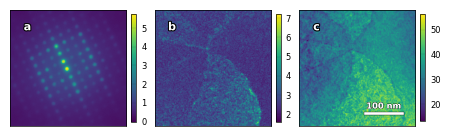

In [ ]:
bright_field_ = (150, 162, 152, 165)
dark_field_ = (106, 123, 110, 125)
filename = "STEM_raw_and_virtual_vortex_domains"
viz.scalebar_ = {"width": 291, "scale length": 100, "units": "nm"}
viz.STEM_raw_and_virtual(
    vortex,
    bright_field_=bright_field_,
    dark_field_=dark_field_,
    scalebar_=True,
    filename=filename,
    shape_=vortex.data.shape,
)

### Builds the Neural Network Model


In [ ]:
encoder_step_size = [256, 256]
pooling_list = [4, 4, 2]
decoder_step_size = [8, 8]
upsampling_list = [2, 4, 4]
embedding_size = 32
conv_size = 128

# set device to load model
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:1"

model = ConvAutoencoder(
    encoder_step_size=encoder_step_size,
    pooling_list=pooling_list,
    decoder_step_size=decoder_step_size,
    upsampling_list=upsampling_list,
    embedding_size=embedding_size,
    conv_size=conv_size,
    device=device,
    learning_rate=3e-5,
)


### Trains or Loads Pretrained Weights


In [ ]:
# set retrain parameter
train = False

if train:
    model.Train(
        vortex.log_data,
        coef_1=1e-5,
        epochs=225,
        with_scheduler=False,
        folder_path="vortex_domains_Weights",
        batch_size=256,
    )

    model.Train(
        vortex.log_data,
        max_learning_rate=5e-5,
        coef_1=5e-4,
        epochs=286,
        epoch_=224,
        with_scheduler=True,
        folder_path="vortex_domains_Weights",
        batch_size=256,
    )
else:
    model.load_weights(
        f"{save_path}/4.5_log_epoch_0285_L1loss_0.0001__lr_0.00003_trainloss_0.2279.pkl"
    )

### Computes the Embeddings


In [ ]:
embedding = model.get_embedding(vortex.log_data)


100%|██████████| 2048/2048 [04:09<00:00,  8.19it/s]


### Visualizes the Embeddings


./../../../Figures/2023_STEM_AE/vortex_domains_embedding_maps.png
./../../../Figures/2023_STEM_AE/vortex_domains_embedding_maps.svg


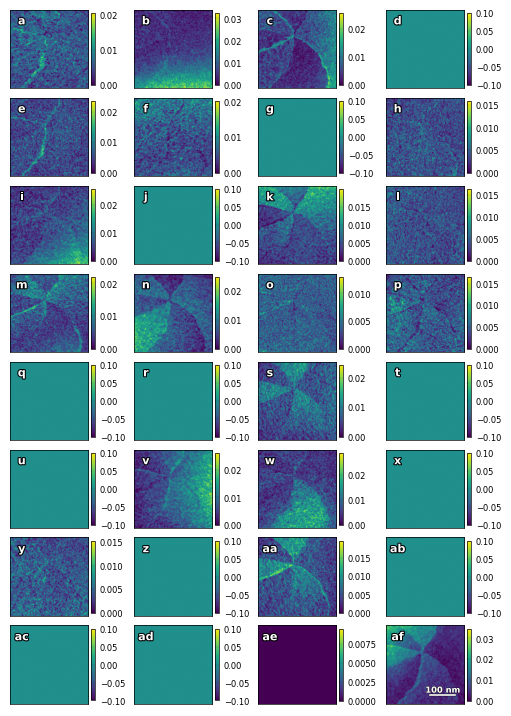

In [ ]:
viz.model = model
viz.channels = None
viz.scalebar_ = {"width": 291, "scale length": 100, "units": "nm"}
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    figsize=(5, 8),
    name="vortex_domains",
    shape_=vortex.data.shape,
)

### Generates Data from the Latent Space

In [ ]:
model.embedding = embedding
viz.model = model
viz.channels = [13, 31]
ranges = [[0, 0.0225], [0, 0.03]]
folder_name = "Generator_of_Figure_4_vortex_domains"

viz.generator_images(
    ranges=ranges,
    folder_name=folder_name,
    figsize=(5, 1.25),
    cbar_number_format="%d",
    shape_=vortex.data.shape,
    divider_=False,
)

  0%|          | 0/200 [00:00<?, ?it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0000_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0000_maps.svg


  0%|          | 1/200 [00:00<03:18,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0001_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0001_maps.svg


  1%|          | 2/200 [00:01<03:16,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0002_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0002_maps.svg


  2%|▏         | 3/200 [00:02<03:15,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0003_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0003_maps.svg


  2%|▏         | 4/200 [00:03<03:15,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0004_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0004_maps.svg


  2%|▎         | 5/200 [00:04<03:13,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0005_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0005_maps.svg


  3%|▎         | 6/200 [00:05<03:12,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0006_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0006_maps.svg


  4%|▎         | 7/200 [00:06<03:11,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0007_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0007_maps.svg


  4%|▍         | 8/200 [00:07<03:10,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0008_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0008_maps.svg


  4%|▍         | 9/200 [00:08<03:09,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0009_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0009_maps.svg


  5%|▌         | 10/200 [00:09<03:08,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0010_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0010_maps.svg


  6%|▌         | 11/200 [00:10<03:07,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0011_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0011_maps.svg


  6%|▌         | 12/200 [00:11<03:06,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0012_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0012_maps.svg


  6%|▋         | 13/200 [00:12<03:05,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0013_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0013_maps.svg


  7%|▋         | 14/200 [00:13<03:04,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0014_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0014_maps.svg


  8%|▊         | 15/200 [00:14<03:03,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0015_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0015_maps.svg


  8%|▊         | 16/200 [00:15<03:02,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0016_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0016_maps.svg


  8%|▊         | 17/200 [00:16<03:01,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0017_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0017_maps.svg


  9%|▉         | 18/200 [00:17<03:00,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0018_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0018_maps.svg


 10%|▉         | 19/200 [00:18<02:59,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0019_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0019_maps.svg


 10%|█         | 20/200 [00:21<04:45,  1.59s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0020_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0020_maps.svg


 10%|█         | 21/200 [00:22<04:12,  1.41s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0021_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0021_maps.svg


 11%|█         | 22/200 [00:23<03:49,  1.29s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0022_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0022_maps.svg


 12%|█▏        | 23/200 [00:24<03:32,  1.20s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0023_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0023_maps.svg


 12%|█▏        | 24/200 [00:25<03:20,  1.14s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0024_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0024_maps.svg


 12%|█▎        | 25/200 [00:26<03:12,  1.10s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0025_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0025_maps.svg


 13%|█▎        | 26/200 [00:27<03:05,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0026_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0026_maps.svg


 14%|█▎        | 27/200 [00:28<03:01,  1.05s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0027_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0027_maps.svg


 14%|█▍        | 28/200 [00:29<02:57,  1.03s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0028_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0028_maps.svg


 14%|█▍        | 29/200 [00:30<02:55,  1.02s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0029_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0029_maps.svg


 15%|█▌        | 30/200 [00:31<02:52,  1.02s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0030_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0030_maps.svg


 16%|█▌        | 31/200 [00:32<02:51,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0031_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0031_maps.svg


 16%|█▌        | 32/200 [00:33<02:49,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0032_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0032_maps.svg


 16%|█▋        | 33/200 [00:35<03:02,  1.09s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0033_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0033_maps.svg


 17%|█▋        | 34/200 [00:36<02:56,  1.06s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0034_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0034_maps.svg


 18%|█▊        | 35/200 [00:37<02:52,  1.05s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0035_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0035_maps.svg


 18%|█▊        | 36/200 [00:38<02:49,  1.03s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0036_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0036_maps.svg


 18%|█▊        | 37/200 [00:39<02:46,  1.02s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0037_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0037_maps.svg


 19%|█▉        | 38/200 [00:40<02:44,  1.02s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0038_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0038_maps.svg


 20%|█▉        | 39/200 [00:41<02:42,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0039_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0039_maps.svg


 20%|██        | 40/200 [00:42<02:41,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0040_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0040_maps.svg


 20%|██        | 41/200 [00:43<02:39,  1.00s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0041_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0041_maps.svg


 21%|██        | 42/200 [00:44<02:38,  1.00s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0042_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0042_maps.svg


 22%|██▏       | 43/200 [00:45<02:37,  1.00s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0043_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0043_maps.svg


 22%|██▏       | 44/200 [00:46<02:35,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0044_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0044_maps.svg


 22%|██▎       | 45/200 [00:47<02:34,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0045_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0045_maps.svg


 23%|██▎       | 46/200 [00:48<02:33,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0046_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0046_maps.svg


 24%|██▎       | 47/200 [00:49<02:32,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0047_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0047_maps.svg


 24%|██▍       | 48/200 [00:50<02:31,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0048_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0048_maps.svg


 24%|██▍       | 49/200 [00:51<02:30,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0049_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0049_maps.svg


 25%|██▌       | 50/200 [00:52<02:45,  1.10s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0050_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0050_maps.svg


 26%|██▌       | 51/200 [00:53<02:39,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0051_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0051_maps.svg


 26%|██▌       | 52/200 [00:54<02:34,  1.05s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0052_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0052_maps.svg


 26%|██▋       | 53/200 [00:55<02:31,  1.03s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0053_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0053_maps.svg


 27%|██▋       | 54/200 [00:56<02:29,  1.02s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0054_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0054_maps.svg


 28%|██▊       | 55/200 [00:57<02:27,  1.02s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0055_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0055_maps.svg


 28%|██▊       | 56/200 [00:58<02:25,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0056_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0056_maps.svg


 28%|██▊       | 57/200 [00:59<02:23,  1.00s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0057_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0057_maps.svg


 29%|██▉       | 58/200 [01:00<02:22,  1.00s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0058_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0058_maps.svg


 30%|██▉       | 59/200 [01:01<02:21,  1.00s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0059_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0059_maps.svg


 30%|███       | 60/200 [01:02<02:19,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0060_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0060_maps.svg


 30%|███       | 61/200 [01:03<02:18,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0061_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0061_maps.svg


 31%|███       | 62/200 [01:04<02:17,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0062_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0062_maps.svg


 32%|███▏      | 63/200 [01:05<02:16,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0063_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0063_maps.svg


 32%|███▏      | 64/200 [01:06<02:15,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0064_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0064_maps.svg


 32%|███▎      | 65/200 [01:07<02:14,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0065_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0065_maps.svg


 33%|███▎      | 66/200 [01:08<02:13,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0066_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0066_maps.svg


 34%|███▎      | 67/200 [01:09<02:12,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0067_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0067_maps.svg


 34%|███▍      | 68/200 [01:10<02:11,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0068_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0068_maps.svg


 34%|███▍      | 69/200 [01:11<02:10,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0069_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0069_maps.svg


 35%|███▌      | 70/200 [01:12<02:09,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0070_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0070_maps.svg


 36%|███▌      | 71/200 [01:13<02:24,  1.12s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0071_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0071_maps.svg


 36%|███▌      | 72/200 [01:14<02:18,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0072_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0072_maps.svg


 36%|███▋      | 73/200 [01:15<02:14,  1.06s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0073_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0073_maps.svg


 37%|███▋      | 74/200 [01:16<02:10,  1.04s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0074_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0074_maps.svg


 38%|███▊      | 75/200 [01:17<02:08,  1.02s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0075_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0075_maps.svg


 38%|███▊      | 76/200 [01:18<02:05,  1.02s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0076_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0076_maps.svg


 38%|███▊      | 77/200 [01:19<02:04,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0077_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0077_maps.svg


 39%|███▉      | 78/200 [01:20<02:02,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0078_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0078_maps.svg


 40%|███▉      | 79/200 [01:21<02:01,  1.00s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0079_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0079_maps.svg


 40%|████      | 80/200 [01:22<02:00,  1.00s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0080_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0080_maps.svg


 40%|████      | 81/200 [01:23<01:58,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0081_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0081_maps.svg


 41%|████      | 82/200 [01:24<01:57,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0082_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0082_maps.svg


 42%|████▏     | 83/200 [01:25<01:56,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0083_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0083_maps.svg


 42%|████▏     | 84/200 [01:26<01:55,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0084_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0084_maps.svg


 42%|████▎     | 85/200 [01:27<01:54,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0085_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0085_maps.svg


 43%|████▎     | 86/200 [01:28<01:53,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0086_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0086_maps.svg


 44%|████▎     | 87/200 [01:29<01:52,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0087_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0087_maps.svg


 44%|████▍     | 88/200 [01:30<01:51,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0088_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0088_maps.svg


 44%|████▍     | 89/200 [01:31<01:50,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0089_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0089_maps.svg


 45%|████▌     | 90/200 [01:32<01:49,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0090_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0090_maps.svg


 46%|████▌     | 91/200 [01:33<01:48,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0091_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0091_maps.svg


 46%|████▌     | 92/200 [01:34<01:47,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0092_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0092_maps.svg


 46%|████▋     | 93/200 [01:35<01:46,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0093_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0093_maps.svg


 47%|████▋     | 94/200 [01:36<01:45,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0094_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0094_maps.svg


 48%|████▊     | 95/200 [01:37<01:44,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0095_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0095_maps.svg


 48%|████▊     | 96/200 [01:38<01:43,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0096_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0096_maps.svg


 48%|████▊     | 97/200 [01:40<01:58,  1.15s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0097_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0097_maps.svg


 49%|████▉     | 98/200 [01:41<01:52,  1.10s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0098_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0098_maps.svg


 50%|████▉     | 99/200 [01:42<01:47,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0099_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0099_maps.svg


 50%|█████     | 100/200 [01:43<01:44,  1.05s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0100_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0100_maps.svg


 50%|█████     | 101/200 [01:44<01:42,  1.03s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0101_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0101_maps.svg


 51%|█████     | 102/200 [01:45<01:39,  1.02s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0102_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0102_maps.svg


 52%|█████▏    | 103/200 [01:46<01:38,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0103_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0103_maps.svg


 52%|█████▏    | 104/200 [01:47<01:36,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0104_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0104_maps.svg


 52%|█████▎    | 105/200 [01:48<01:35,  1.00s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0105_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0105_maps.svg


 53%|█████▎    | 106/200 [01:49<01:34,  1.00s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0106_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0106_maps.svg


 54%|█████▎    | 107/200 [01:50<01:32,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0107_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0107_maps.svg


 54%|█████▍    | 108/200 [01:51<01:31,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0108_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0108_maps.svg


 55%|█████▍    | 109/200 [01:52<01:30,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0109_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0109_maps.svg


 55%|█████▌    | 110/200 [01:53<01:29,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0110_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0110_maps.svg


 56%|█████▌    | 111/200 [01:54<01:28,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0111_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0111_maps.svg


 56%|█████▌    | 112/200 [01:55<01:27,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0112_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0112_maps.svg


 56%|█████▋    | 113/200 [01:56<01:26,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0113_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0113_maps.svg


 57%|█████▋    | 114/200 [01:57<01:25,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0114_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0114_maps.svg


 57%|█████▊    | 115/200 [01:58<01:24,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0115_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0115_maps.svg


 58%|█████▊    | 116/200 [01:59<01:23,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0116_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0116_maps.svg


 58%|█████▊    | 117/200 [02:00<01:22,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0117_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0117_maps.svg


 59%|█████▉    | 118/200 [02:01<01:21,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0118_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0118_maps.svg


 60%|█████▉    | 119/200 [02:02<01:20,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0119_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0119_maps.svg


 60%|██████    | 120/200 [02:03<01:19,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0120_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0120_maps.svg


 60%|██████    | 121/200 [02:03<01:18,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0121_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0121_maps.svg


 61%|██████    | 122/200 [02:04<01:17,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0122_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0122_maps.svg


 62%|██████▏   | 123/200 [02:05<01:16,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0123_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0123_maps.svg


 62%|██████▏   | 124/200 [02:06<01:15,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0124_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0124_maps.svg


 62%|██████▎   | 125/200 [02:07<01:14,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0125_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0125_maps.svg


 63%|██████▎   | 126/200 [02:08<01:13,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0126_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0126_maps.svg


 64%|██████▎   | 127/200 [02:09<01:12,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0127_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0127_maps.svg


 64%|██████▍   | 128/200 [02:10<01:11,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0128_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0128_maps.svg


 64%|██████▍   | 129/200 [02:11<01:10,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0129_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0129_maps.svg


 65%|██████▌   | 130/200 [02:13<01:22,  1.18s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0130_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0130_maps.svg


 66%|██████▌   | 131/200 [02:14<01:17,  1.13s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0131_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0131_maps.svg


 66%|██████▌   | 132/200 [02:15<01:13,  1.09s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0132_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0132_maps.svg


 66%|██████▋   | 133/200 [02:16<01:10,  1.06s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0133_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0133_maps.svg


 67%|██████▋   | 134/200 [02:17<01:08,  1.04s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0134_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0134_maps.svg


 68%|██████▊   | 135/200 [02:18<01:06,  1.02s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0135_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0135_maps.svg


 68%|██████▊   | 136/200 [02:19<01:04,  1.02s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0136_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0136_maps.svg


 68%|██████▊   | 137/200 [02:20<01:03,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0137_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0137_maps.svg


 69%|██████▉   | 138/200 [02:21<01:02,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0138_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0138_maps.svg


 70%|██████▉   | 139/200 [02:22<01:01,  1.00s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0139_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0139_maps.svg


 70%|███████   | 140/200 [02:23<00:59,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0140_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0140_maps.svg


 70%|███████   | 141/200 [02:24<00:58,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0141_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0141_maps.svg


 71%|███████   | 142/200 [02:25<00:57,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0142_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0142_maps.svg


 72%|███████▏  | 143/200 [02:26<00:56,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0143_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0143_maps.svg


 72%|███████▏  | 144/200 [02:27<00:55,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0144_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0144_maps.svg


 72%|███████▎  | 145/200 [02:28<00:54,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0145_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0145_maps.svg


 73%|███████▎  | 146/200 [02:29<00:53,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0146_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0146_maps.svg


 74%|███████▎  | 147/200 [02:30<00:52,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0147_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0147_maps.svg


 74%|███████▍  | 148/200 [02:31<00:51,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0148_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0148_maps.svg


 74%|███████▍  | 149/200 [02:32<00:50,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0149_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0149_maps.svg


 75%|███████▌  | 150/200 [02:33<00:49,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0150_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0150_maps.svg


 76%|███████▌  | 151/200 [02:34<00:48,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0151_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0151_maps.svg


 76%|███████▌  | 152/200 [02:35<00:47,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0152_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0152_maps.svg


 76%|███████▋  | 153/200 [02:36<00:46,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0153_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0153_maps.svg


 77%|███████▋  | 154/200 [02:37<00:45,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0154_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0154_maps.svg


 78%|███████▊  | 155/200 [02:38<00:44,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0155_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0155_maps.svg


 78%|███████▊  | 156/200 [02:39<00:43,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0156_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0156_maps.svg


 78%|███████▊  | 157/200 [02:40<00:42,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0157_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0157_maps.svg


 79%|███████▉  | 158/200 [02:41<00:41,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0158_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0158_maps.svg


 80%|███████▉  | 159/200 [02:42<00:40,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0159_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0159_maps.svg


 80%|████████  | 160/200 [02:43<00:39,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0160_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0160_maps.svg


 80%|████████  | 161/200 [02:44<00:38,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0161_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0161_maps.svg


 81%|████████  | 162/200 [02:45<00:37,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0162_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0162_maps.svg


 82%|████████▏ | 163/200 [02:46<00:36,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0163_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0163_maps.svg


 82%|████████▏ | 164/200 [02:47<00:35,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0164_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0164_maps.svg


 82%|████████▎ | 165/200 [02:48<00:34,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0165_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0165_maps.svg


 83%|████████▎ | 166/200 [02:49<00:33,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0166_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0166_maps.svg


 84%|████████▎ | 167/200 [02:50<00:32,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0167_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0167_maps.svg


 84%|████████▍ | 168/200 [02:51<00:31,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0168_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0168_maps.svg


 84%|████████▍ | 169/200 [02:52<00:30,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0169_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0169_maps.svg


 85%|████████▌ | 170/200 [02:54<00:36,  1.23s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0170_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0170_maps.svg


 86%|████████▌ | 171/200 [02:55<00:33,  1.16s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0171_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0171_maps.svg


 86%|████████▌ | 172/200 [02:56<00:31,  1.11s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0172_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0172_maps.svg


 86%|████████▋ | 173/200 [02:57<00:29,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0173_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0173_maps.svg


 87%|████████▋ | 174/200 [02:58<00:27,  1.05s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0174_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0174_maps.svg


 88%|████████▊ | 175/200 [02:59<00:25,  1.03s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0175_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0175_maps.svg


 88%|████████▊ | 176/200 [03:00<00:24,  1.02s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0176_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0176_maps.svg


 88%|████████▊ | 177/200 [03:01<00:23,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0177_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0177_maps.svg


 89%|████████▉ | 178/200 [03:02<00:22,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0178_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0178_maps.svg


 90%|████████▉ | 179/200 [03:03<00:21,  1.00s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0179_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0179_maps.svg


 90%|█████████ | 180/200 [03:04<00:20,  1.00s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0180_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0180_maps.svg


 90%|█████████ | 181/200 [03:05<00:18,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0181_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0181_maps.svg


 91%|█████████ | 182/200 [03:06<00:17,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0182_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0182_maps.svg


 92%|█████████▏| 183/200 [03:07<00:16,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0183_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0183_maps.svg


 92%|█████████▏| 184/200 [03:08<00:15,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0184_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0184_maps.svg


 92%|█████████▎| 185/200 [03:09<00:14,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0185_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0185_maps.svg


 93%|█████████▎| 186/200 [03:10<00:13,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0186_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0186_maps.svg


 94%|█████████▎| 187/200 [03:11<00:12,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0187_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0187_maps.svg


 94%|█████████▍| 188/200 [03:12<00:11,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0188_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0188_maps.svg


 94%|█████████▍| 189/200 [03:13<00:10,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0189_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0189_maps.svg


 95%|█████████▌| 190/200 [03:14<00:09,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0190_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0190_maps.svg


 96%|█████████▌| 191/200 [03:15<00:08,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0191_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0191_maps.svg


 96%|█████████▌| 192/200 [03:16<00:07,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0192_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0192_maps.svg


 96%|█████████▋| 193/200 [03:16<00:06,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0193_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0193_maps.svg


 97%|█████████▋| 194/200 [03:17<00:05,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0194_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0194_maps.svg


 98%|█████████▊| 195/200 [03:18<00:04,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0195_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0195_maps.svg


 98%|█████████▊| 196/200 [03:19<00:03,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0196_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0196_maps.svg


 98%|█████████▊| 197/200 [03:20<00:02,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0197_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0197_maps.svg


 99%|█████████▉| 198/200 [03:21<00:01,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0198_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0198_maps.svg


100%|█████████▉| 199/200 [03:22<00:00,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0199_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_vortex_domains/0199_maps.svg


100%|██████████| 200/200 [03:23<00:00,  1.02s/it]


### Builds the Movie

In [ ]:
# Builds a Movie
folder = f"{fig_path}/generator_images_Generator_of_Figure_4_vortex_domains/"
output_folder = "./movies/"

# function to make the movie
make_movie("Vortex Domains Generator", folder, output_folder, "png", 3)

## Vortex Domain Walls


### Builds the Neural Network Model


In [ ]:
encoder_step_size = [256, 256]
pooling_list = [4, 4, 2]
decoder_step_size = [8, 8]
upsampling_list = [2, 4, 4]
embedding_size = 32
conv_size = 128

# set device to load model
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:1"

model = ConvAutoencoder(
    encoder_step_size=encoder_step_size,
    pooling_list=pooling_list,
    decoder_step_size=decoder_step_size,
    upsampling_list=upsampling_list,
    embedding_size=embedding_size,
    conv_size=conv_size,
    device=device,
    learning_rate=3e-5,
)


### Trains or Loads Pretrained Weights


In this model we have additional custom regularization to the embedding to help with disentangling the vortices from the walls.

1. We have an l1 activity regularization:

$$ \sum\_{i=1}^{n} |a_i| $$

2. We have a contrastive regularization:

$$ L = \frac{\lambda*1}{2N} \sum\limits*{i=1}^{N} \left[\left(\sum\limits_{j=1, j\neq i}^{N} \frac{latent_i \cdot latent_j}{\left\lVert latent_i \right\rVert \left\lVert latent_j \right\rVert}\right] - 1\right)$$

3. Divergence regularization:

$$L = \frac{1}{B} \sum\limits_{i=1}^{B} \left(\frac{\lambda_2}{2} \sum\limits_{j=1}^{n} \sum\limits_{k=j+1}^{n} \left| latent_{i,j} - latent_{i,k} \right|\right)$$


In [ ]:
# set retrain parameter
train = False

if train:
    model.Train(
        vortex.log_data,
        coef_0=5e-3,
        coef_1=5e-5,
        coef_2=2e-4,
        epochs=18,
        with_scheduler=False,
        folder_path="Vortex_walls_Weights",
        batch_size=256,
    )
else:
    model.load_weights(
        f"{save_path}/11.1_log_epoch_0017_L1loss_0.00181_l1coef_0.0050_lr_0.00009_contrasPara_0.000050_contrasLoss_0.00020_maxiPara_0.00070_maxiLoss_0.0019_trainloss_0.2289.pkl"
    )

### Computes the Embeddings


In [ ]:
embedding = model.get_embedding(vortex.log_data)


100%|██████████| 2048/2048 [04:09<00:00,  8.20it/s]


### Visualizes the Embeddings


./../../../Figures/2023_STEM_AE/Vortex_walls_embedding_maps.png
./../../../Figures/2023_STEM_AE/Vortex_walls_embedding_maps.svg


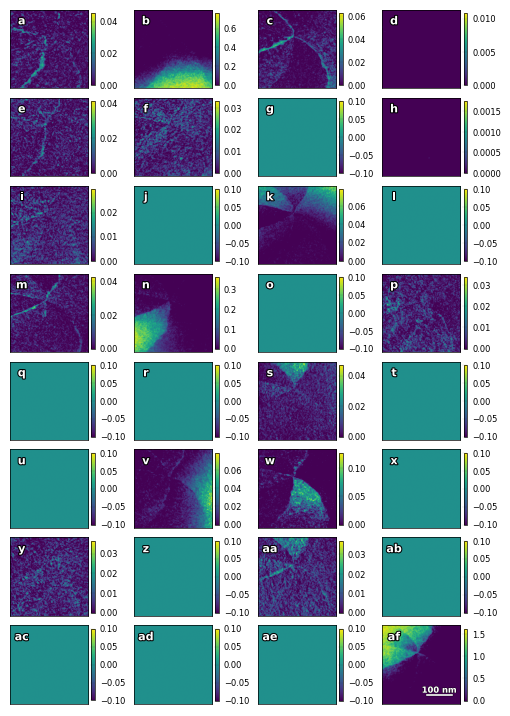

In [ ]:
viz.channels = None
viz.model = model
viz.scalebar_ = {"width": 291, "scale length": 100, "units": "nm"}
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    figsize=(5, 8),
    name="Vortex_walls",
    shape_=vortex.data.shape,
)

### Generates Data from the Latent Space

In [ ]:
model.embedding = embedding
viz.model = model
viz.channels = [0, 2]
ranges = [[0, 0.025], [0, 0.04]]
folder_name = "Generator_of_Figure_4_e_f_vortex_walls"

viz.generator_images(
    ranges=ranges,
    folder_name=folder_name,
    figsize=(5, 1.25),
    cbar_number_format="%d",
    shape_=vortex.data.shape,
    divider_=False,
)

  0%|          | 0/200 [00:00<?, ?it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0000_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0000_maps.svg


  0%|          | 1/200 [00:00<03:14,  1.02it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0001_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0001_maps.svg


  1%|          | 2/200 [00:01<03:11,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0002_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0002_maps.svg


  2%|▏         | 3/200 [00:02<03:09,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0003_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0003_maps.svg


  2%|▏         | 4/200 [00:03<03:07,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0004_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0004_maps.svg


  2%|▎         | 5/200 [00:04<03:05,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0005_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0005_maps.svg


  3%|▎         | 6/200 [00:05<03:04,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0006_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0006_maps.svg


  4%|▎         | 7/200 [00:06<03:03,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0007_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0007_maps.svg


  4%|▍         | 8/200 [00:07<03:02,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0008_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0008_maps.svg


  4%|▍         | 9/200 [00:08<03:01,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0009_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0009_maps.svg


  5%|▌         | 10/200 [00:11<05:01,  1.59s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0010_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0010_maps.svg


  6%|▌         | 11/200 [00:12<04:23,  1.40s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0011_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0011_maps.svg


  6%|▌         | 12/200 [00:13<03:57,  1.27s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0012_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0012_maps.svg


  6%|▋         | 13/200 [00:14<03:39,  1.17s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0013_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0013_maps.svg


  7%|▋         | 14/200 [00:15<03:26,  1.11s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0014_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0014_maps.svg


  8%|▊         | 15/200 [00:16<03:16,  1.06s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0015_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0015_maps.svg


  8%|▊         | 16/200 [00:17<03:10,  1.03s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0016_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0016_maps.svg


  8%|▊         | 17/200 [00:18<03:05,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0017_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0017_maps.svg


  9%|▉         | 18/200 [00:19<03:01,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0018_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0018_maps.svg


 10%|▉         | 19/200 [00:20<02:58,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0019_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0019_maps.svg


 10%|█         | 20/200 [00:21<02:56,  1.02it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0020_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0020_maps.svg


 10%|█         | 21/200 [00:22<02:54,  1.03it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0021_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0021_maps.svg


 11%|█         | 22/200 [00:23<03:05,  1.04s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0022_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0022_maps.svg


 12%|█▏        | 23/200 [00:24<03:00,  1.02s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0023_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0023_maps.svg


 12%|█▏        | 24/200 [00:25<02:56,  1.00s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0024_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0024_maps.svg


 12%|█▎        | 25/200 [00:26<02:52,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0025_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0025_maps.svg


 13%|█▎        | 26/200 [00:27<02:50,  1.02it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0026_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0026_maps.svg


 14%|█▎        | 27/200 [00:28<02:48,  1.02it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0027_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0027_maps.svg


 14%|█▍        | 28/200 [00:29<02:46,  1.03it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0028_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0028_maps.svg


 14%|█▍        | 29/200 [00:30<02:45,  1.03it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0029_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0029_maps.svg


 15%|█▌        | 30/200 [00:31<02:43,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0030_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0030_maps.svg


 16%|█▌        | 31/200 [00:32<02:42,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0031_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0031_maps.svg


 16%|█▌        | 32/200 [00:33<02:41,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0032_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0032_maps.svg


 16%|█▋        | 33/200 [00:33<02:40,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0033_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0033_maps.svg


 17%|█▋        | 34/200 [00:34<02:39,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0034_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0034_maps.svg


 18%|█▊        | 35/200 [00:35<02:38,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0035_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0035_maps.svg


 18%|█▊        | 36/200 [00:37<02:52,  1.05s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0036_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0036_maps.svg


 18%|█▊        | 37/200 [00:38<02:47,  1.03s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0037_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0037_maps.svg


 19%|█▉        | 38/200 [00:39<02:42,  1.00s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0038_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0038_maps.svg


 20%|█▉        | 39/200 [00:40<02:39,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0039_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0039_maps.svg


 20%|██        | 40/200 [00:40<02:37,  1.02it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0040_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0040_maps.svg


 20%|██        | 41/200 [00:41<02:35,  1.02it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0041_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0041_maps.svg


 21%|██        | 42/200 [00:42<02:33,  1.03it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0042_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0042_maps.svg


 22%|██▏       | 43/200 [00:43<02:32,  1.03it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0043_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0043_maps.svg


 22%|██▏       | 44/200 [00:44<02:30,  1.03it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0044_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0044_maps.svg


 22%|██▎       | 45/200 [00:45<02:29,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0045_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0045_maps.svg


 23%|██▎       | 46/200 [00:46<02:28,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0046_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0046_maps.svg


 24%|██▎       | 47/200 [00:47<02:27,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0047_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0047_maps.svg


 24%|██▍       | 48/200 [00:48<02:26,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0048_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0048_maps.svg


 24%|██▍       | 49/200 [00:49<02:25,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0049_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0049_maps.svg


 25%|██▌       | 50/200 [00:50<02:24,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0050_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0050_maps.svg


 26%|██▌       | 51/200 [00:51<02:23,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0051_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0051_maps.svg


 26%|██▌       | 52/200 [00:52<02:21,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0052_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0052_maps.svg


 26%|██▋       | 53/200 [00:53<02:20,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0053_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0053_maps.svg


 27%|██▋       | 54/200 [00:54<02:36,  1.07s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0054_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0054_maps.svg


 28%|██▊       | 55/200 [00:55<02:30,  1.04s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0055_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0055_maps.svg


 28%|██▊       | 56/200 [00:56<02:26,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0056_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0056_maps.svg


 28%|██▊       | 57/200 [00:57<02:22,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0057_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0057_maps.svg


 29%|██▉       | 58/200 [00:58<02:20,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0058_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0058_maps.svg


 30%|██▉       | 59/200 [00:59<02:17,  1.02it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0059_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0059_maps.svg


 30%|███       | 60/200 [01:00<02:16,  1.03it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0060_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0060_maps.svg


 30%|███       | 61/200 [01:01<02:14,  1.03it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0061_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0061_maps.svg


 31%|███       | 62/200 [01:02<02:13,  1.03it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0062_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0062_maps.svg


 32%|███▏      | 63/200 [01:03<02:12,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0063_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0063_maps.svg


 32%|███▏      | 64/200 [01:04<02:11,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0064_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0064_maps.svg


 32%|███▎      | 65/200 [01:05<02:09,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0065_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0065_maps.svg


 33%|███▎      | 66/200 [01:06<02:08,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0066_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0066_maps.svg


 34%|███▎      | 67/200 [01:07<02:07,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0067_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0067_maps.svg


 34%|███▍      | 68/200 [01:08<02:06,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0068_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0068_maps.svg


 34%|███▍      | 69/200 [01:09<02:05,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0069_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0069_maps.svg


 35%|███▌      | 70/200 [01:10<02:04,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0070_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0070_maps.svg


 36%|███▌      | 71/200 [01:11<02:03,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0071_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0071_maps.svg


 36%|███▌      | 72/200 [01:12<02:03,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0072_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0072_maps.svg


 36%|███▋      | 73/200 [01:13<02:01,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0073_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0073_maps.svg


 37%|███▋      | 74/200 [01:13<02:01,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0074_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0074_maps.svg


 38%|███▊      | 75/200 [01:14<02:00,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0075_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0075_maps.svg


 38%|███▊      | 76/200 [01:16<02:16,  1.10s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0076_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0076_maps.svg


 38%|███▊      | 77/200 [01:17<02:10,  1.06s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0077_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0077_maps.svg


 39%|███▉      | 78/200 [01:18<02:05,  1.03s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0078_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0078_maps.svg


 40%|███▉      | 79/200 [01:19<02:01,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0079_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0079_maps.svg


 40%|████      | 80/200 [01:20<01:59,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0080_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0080_maps.svg


 40%|████      | 81/200 [01:21<01:56,  1.02it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0081_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0081_maps.svg


 41%|████      | 82/200 [01:22<01:55,  1.03it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0082_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0082_maps.svg


 42%|████▏     | 83/200 [01:23<01:53,  1.03it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0083_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0083_maps.svg


 42%|████▏     | 84/200 [01:24<01:52,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0084_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0084_maps.svg


 42%|████▎     | 85/200 [01:25<01:50,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0085_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0085_maps.svg


 43%|████▎     | 86/200 [01:25<01:49,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0086_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0086_maps.svg


 44%|████▎     | 87/200 [01:26<01:48,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0087_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0087_maps.svg


 44%|████▍     | 88/200 [01:27<01:47,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0088_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0088_maps.svg


 44%|████▍     | 89/200 [01:28<01:46,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0089_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0089_maps.svg


 45%|████▌     | 90/200 [01:29<01:45,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0090_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0090_maps.svg


 46%|████▌     | 91/200 [01:30<01:44,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0091_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0091_maps.svg


 46%|████▌     | 92/200 [01:31<01:43,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0092_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0092_maps.svg


 46%|████▋     | 93/200 [01:32<01:42,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0093_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0093_maps.svg


 47%|████▋     | 94/200 [01:33<01:41,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0094_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0094_maps.svg


 48%|████▊     | 95/200 [01:34<01:40,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0095_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0095_maps.svg


 48%|████▊     | 96/200 [01:35<01:39,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0096_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0096_maps.svg


 48%|████▊     | 97/200 [01:36<01:38,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0097_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0097_maps.svg


 49%|████▉     | 98/200 [01:37<01:37,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0098_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0098_maps.svg


 50%|████▉     | 99/200 [01:38<01:36,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0099_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0099_maps.svg


 50%|█████     | 100/200 [01:39<01:35,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0100_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0100_maps.svg


 50%|█████     | 101/200 [01:40<01:34,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0101_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0101_maps.svg


 51%|█████     | 102/200 [01:41<01:33,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0102_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0102_maps.svg


 52%|█████▏    | 103/200 [01:42<01:49,  1.13s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0103_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0103_maps.svg


 52%|█████▏    | 104/200 [01:43<01:43,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0104_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0104_maps.svg


 52%|█████▎    | 105/200 [01:44<01:39,  1.04s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0105_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0105_maps.svg


 53%|█████▎    | 106/200 [01:45<01:35,  1.02s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0106_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0106_maps.svg


 54%|█████▎    | 107/200 [01:46<01:32,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0107_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0107_maps.svg


 54%|█████▍    | 108/200 [01:47<01:30,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0108_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0108_maps.svg


 55%|█████▍    | 109/200 [01:48<01:28,  1.02it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0109_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0109_maps.svg


 55%|█████▌    | 110/200 [01:49<01:27,  1.03it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0110_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0110_maps.svg


 56%|█████▌    | 111/200 [01:50<01:25,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0111_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0111_maps.svg


 56%|█████▌    | 112/200 [01:51<01:24,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0112_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0112_maps.svg


 56%|█████▋    | 113/200 [01:52<01:23,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0113_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0113_maps.svg


 57%|█████▋    | 114/200 [01:53<01:22,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0114_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0114_maps.svg


 57%|█████▊    | 115/200 [01:54<01:21,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0115_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0115_maps.svg


 58%|█████▊    | 116/200 [01:55<01:20,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0116_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0116_maps.svg


 58%|█████▊    | 117/200 [01:56<01:19,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0117_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0117_maps.svg


 59%|█████▉    | 118/200 [01:57<01:18,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0118_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0118_maps.svg


 60%|█████▉    | 119/200 [01:58<01:17,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0119_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0119_maps.svg


 60%|██████    | 120/200 [01:59<01:16,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0120_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0120_maps.svg


 60%|██████    | 121/200 [02:00<01:15,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0121_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0121_maps.svg


 61%|██████    | 122/200 [02:01<01:14,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0122_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0122_maps.svg


 62%|██████▏   | 123/200 [02:01<01:13,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0123_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0123_maps.svg


 62%|██████▏   | 124/200 [02:02<01:12,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0124_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0124_maps.svg


 62%|██████▎   | 125/200 [02:03<01:11,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0125_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0125_maps.svg


 63%|██████▎   | 126/200 [02:04<01:10,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0126_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0126_maps.svg


 64%|██████▎   | 127/200 [02:05<01:09,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0127_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0127_maps.svg


 64%|██████▍   | 128/200 [02:06<01:08,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0128_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0128_maps.svg


 64%|██████▍   | 129/200 [02:07<01:08,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0129_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0129_maps.svg


 65%|██████▌   | 130/200 [02:08<01:07,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0130_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0130_maps.svg


 66%|██████▌   | 131/200 [02:09<01:06,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0131_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0131_maps.svg


 66%|██████▌   | 132/200 [02:10<01:05,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0132_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0132_maps.svg


 66%|██████▋   | 133/200 [02:11<01:04,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0133_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0133_maps.svg


 67%|██████▋   | 134/200 [02:12<01:03,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0134_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0134_maps.svg


 68%|██████▊   | 135/200 [02:13<01:02,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0135_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0135_maps.svg


 68%|██████▊   | 136/200 [02:14<01:01,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0136_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0136_maps.svg


 68%|██████▊   | 137/200 [02:15<01:00,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0137_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0137_maps.svg


 69%|██████▉   | 138/200 [02:16<01:11,  1.16s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0138_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0138_maps.svg


 70%|██████▉   | 139/200 [02:17<01:06,  1.10s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0139_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0139_maps.svg


 70%|███████   | 140/200 [02:18<01:03,  1.05s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0140_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0140_maps.svg


 70%|███████   | 141/200 [02:19<01:00,  1.02s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0141_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0141_maps.svg


 71%|███████   | 142/200 [02:20<00:58,  1.00s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0142_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0142_maps.svg


 72%|███████▏  | 143/200 [02:21<00:56,  1.01it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0143_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0143_maps.svg


 72%|███████▏  | 144/200 [02:22<00:54,  1.02it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0144_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0144_maps.svg


 72%|███████▎  | 145/200 [02:23<00:53,  1.03it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0145_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0145_maps.svg


 73%|███████▎  | 146/200 [02:24<00:52,  1.03it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0146_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0146_maps.svg


 74%|███████▎  | 147/200 [02:25<00:51,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0147_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0147_maps.svg


 74%|███████▍  | 148/200 [02:26<00:49,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0148_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0148_maps.svg


 74%|███████▍  | 149/200 [02:27<00:48,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0149_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0149_maps.svg


 75%|███████▌  | 150/200 [02:28<00:47,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0150_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0150_maps.svg


 76%|███████▌  | 151/200 [02:29<00:46,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0151_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0151_maps.svg


 76%|███████▌  | 152/200 [02:30<00:45,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0152_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0152_maps.svg


 76%|███████▋  | 153/200 [02:31<00:44,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0153_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0153_maps.svg


 77%|███████▋  | 154/200 [02:32<00:43,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0154_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0154_maps.svg


 78%|███████▊  | 155/200 [02:33<00:42,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0155_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0155_maps.svg


 78%|███████▊  | 156/200 [02:34<00:41,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0156_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0156_maps.svg


 78%|███████▊  | 157/200 [02:35<00:40,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0157_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0157_maps.svg


 79%|███████▉  | 158/200 [02:36<00:40,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0158_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0158_maps.svg


 80%|███████▉  | 159/200 [02:37<00:39,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0159_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0159_maps.svg


 80%|████████  | 160/200 [02:37<00:38,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0160_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0160_maps.svg


 80%|████████  | 161/200 [02:38<00:37,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0161_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0161_maps.svg


 81%|████████  | 162/200 [02:39<00:36,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0162_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0162_maps.svg


 82%|████████▏ | 163/200 [02:40<00:35,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0163_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0163_maps.svg


 82%|████████▏ | 164/200 [02:41<00:34,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0164_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0164_maps.svg


 82%|████████▎ | 165/200 [02:42<00:33,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0165_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0165_maps.svg


 83%|████████▎ | 166/200 [02:43<00:32,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0166_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0166_maps.svg


 84%|████████▎ | 167/200 [02:44<00:31,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0167_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0167_maps.svg


 84%|████████▍ | 168/200 [02:45<00:30,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0168_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0168_maps.svg


 84%|████████▍ | 169/200 [02:46<00:29,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0169_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0169_maps.svg


 85%|████████▌ | 170/200 [02:47<00:28,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0170_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0170_maps.svg


 86%|████████▌ | 171/200 [02:48<00:27,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0171_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0171_maps.svg


 86%|████████▌ | 172/200 [02:49<00:26,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0172_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0172_maps.svg


 86%|████████▋ | 173/200 [02:50<00:25,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0173_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0173_maps.svg


 87%|████████▋ | 174/200 [02:51<00:24,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0174_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0174_maps.svg


 88%|████████▊ | 175/200 [02:52<00:23,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0175_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0175_maps.svg


 88%|████████▊ | 176/200 [02:53<00:22,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0176_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0176_maps.svg


 88%|████████▊ | 177/200 [02:54<00:21,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0177_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0177_maps.svg


 89%|████████▉ | 178/200 [02:55<00:20,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0178_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0178_maps.svg


 90%|████████▉ | 179/200 [02:56<00:20,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0179_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0179_maps.svg


 90%|█████████ | 180/200 [02:57<00:24,  1.20s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0180_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0180_maps.svg


 90%|█████████ | 181/200 [02:58<00:21,  1.13s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0181_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0181_maps.svg


 91%|█████████ | 182/200 [02:59<00:19,  1.08s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0182_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0182_maps.svg


 92%|█████████▏| 183/200 [03:00<00:17,  1.04s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0183_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0183_maps.svg


 92%|█████████▏| 184/200 [03:01<00:16,  1.01s/it]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0184_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0184_maps.svg


 92%|█████████▎| 185/200 [03:02<00:14,  1.00it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0185_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0185_maps.svg


 93%|█████████▎| 186/200 [03:03<00:13,  1.02it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0186_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0186_maps.svg


 94%|█████████▎| 187/200 [03:04<00:12,  1.03it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0187_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0187_maps.svg


 94%|█████████▍| 188/200 [03:05<00:11,  1.03it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0188_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0188_maps.svg


 94%|█████████▍| 189/200 [03:06<00:10,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0189_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0189_maps.svg


 95%|█████████▌| 190/200 [03:07<00:09,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0190_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0190_maps.svg


 96%|█████████▌| 191/200 [03:08<00:08,  1.04it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0191_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0191_maps.svg


 96%|█████████▌| 192/200 [03:09<00:07,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0192_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0192_maps.svg


 96%|█████████▋| 193/200 [03:10<00:06,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0193_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0193_maps.svg


 97%|█████████▋| 194/200 [03:11<00:05,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0194_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0194_maps.svg


 98%|█████████▊| 195/200 [03:12<00:04,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0195_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0195_maps.svg


 98%|█████████▊| 196/200 [03:13<00:03,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0196_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0196_maps.svg


 98%|█████████▊| 197/200 [03:14<00:02,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0197_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0197_maps.svg


 99%|█████████▉| 198/200 [03:15<00:01,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0198_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0198_maps.svg


100%|█████████▉| 199/200 [03:15<00:00,  1.05it/s]

./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0199_maps.png
./../../../Figures/2023_STEM_AE/generator_images_Generator_of_Figure_4_e_f_vortex_walls/0199_maps.svg


100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


### Builds a Movie


In [ ]:
folder = f"{fig_path}/generator_images_Generator_of_Figure_4_e_f_vortex_walls/"
output_folder = "./movies/"

# function to make the movie
make_movie("Vortex Wall Generator", folder, output_folder, "png", 3)